# Packages

In [1]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba

from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import vstack
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [2]:
current_dir = %pwd

In [3]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [4]:
# Extract glitches and IFO ---> ONLY ONCE
L1_filename = "L1_glitches.txt"
H1_filename = "H1_glitches.txt"

glitch_names_L1 = set()
glitch_names_H1 = set()

for root, _, files in os.walk(train_dir):
    for filename in files:
        if filename.startswith("H1_"):
            parts = filename.split("_")
            if len(parts) >= 3:
                glitch_names_H1.add(parts[1])
        if filename.startswith("L1_"):
            parts = filename.split("_")
            if len(parts) >=2:
                glitch_names_L1.add(parts[1])

with open(os.path.join(current_dir, L1_filename), "w") as output_file:
    for name in glitch_names_L1:
        output_file.write(f"{name}\n")
        
with open(os.path.join(current_dir, H1_filename), "w") as output_file:
    for name in glitch_names_H1:
        output_file.write(f"{name}\n")

In [5]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"
glitch_labels = ['1400Ripples', '1080Lines', 'Air_Compressor', 
                 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 
                 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 
                 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 
                 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
O3b_start = 1256655618
O3b_stop = 1269363618

In [6]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

In [7]:
glitch_id = 'M09XzQgn81'

In [8]:
glitch_start_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])-2
glitch_stop_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])+2

In [9]:
step = 0.25
sampling_rate = 16384
#sampling_rate = 512
decimate = 64
channel = 'L1:DCS-CALIB_STRAIN_C01_AR'
#channel = 'L1:PEM-EY_MIC_VEA_PLUSY_DQ'
#channel = 'L1:LSC-PRCL_IN1_DQ'
#channel = 'L1:LSC-PRCL_OUT_DQ'
#channel = 'L1:ASC-CHARD_Y_OUT_DQ'
server = 'losc-nds.ligo.org'
#server = 'nds.gwosc.org'
alpha = 1
data_end = sampling_rate * (glitch_stop_time - glitch_start_time)
data = pd.DataFrame(columns=['time', 'value'])
data_length = int((glitch_stop_time - glitch_start_time) / step)

In [10]:
chanList = ChannelList.query_nds2('*', host=server)
print("Found {0} channels\n".format(len(chanList)))
print("Printing first 10 channels ...")
auxlist = [chan for chan in chanList if 'L1:LSC-PRCL_IN1_DQ' in chan.name]
print("Here are channels containing L1 in the name ...")
for chan in auxlist:
    print(chan.name, chan.sample_rate)

Found 1294 channels

Printing first 10 channels ...
Here are channels containing L1 in the name ...
L1:LSC-PRCL_IN1_DQ 16384.0 Hz
L1:LSC-PRCL_IN1_DQ 16384.0 Hz


In [11]:
data_conditioned = my_gwpy_and_fractals.fetch_and_whiten_data(glitch_start_time, glitch_stop_time, server, sampling_rate, channel)

Getting the TimeSeries data
fetch_and_whiten_data: 6954.301834106445 ms


In [12]:
data_conditioned

array([-0.76128244,  1.33003165,  0.54845899, ..., -0.19367836,
        1.99329437, -0.67867828])

In [13]:
time_stamps = np.arange(0, int(data_end/2))
time_stamps_array = np.split(time_stamps, data_length)
for element in time_stamps_array:
    try:
        data = pd.concat([data, pd.DataFrame(pd.Series([element, data_conditioned[element]], index=['time', 'value'])).T], ignore_index=True)
    except:
        print('No data or exception')
        pass

In [14]:
len(data_conditioned)

32768

In [15]:
number_of_chunks = data_length
data_fd = pd.DataFrame(columns=['time', 'fd'])

for chunk in range(0, number_of_chunks):
    start_chunktime = chunk * step + glitch_start_time
    check_valid = data.iloc[chunk].value
    if np.isnan(check_valid.all()):
        print(f"Warning, undefined data, FD is set to zero at time {start_chunktime}.")
        continue
    print(f"Computing the var estimator for data starting at {start_chunktime} time.")
    #print(data.iloc[chunk])
    est_eval = my_gwpy_and_fractals.var_function(data.iloc[chunk], decimate)
    est_fit = my_gwpy_and_fractals.fit_est(est_eval, sampling_rate)
    fractal_dimension = 2.-est_fit[3]
    print(f"fd= {fractal_dimension}")
    data_fd = pd.concat([data_fd, pd.DataFrame([[start_chunktime, fractal_dimension]], columns=['time', 'fd'])], ignore_index=True) 

Computing the var estimator for data starting at 1258107541.0 time.
var_function: 1947.5643634796143 ms
fit_est: 10.934114456176758 ms
fd= 1.6847732097414179
Computing the var estimator for data starting at 1258107541.25 time.
var_function: 2.2521018981933594 ms
fit_est: 0.4391670227050781 ms
fd= 1.690433246860981
Computing the var estimator for data starting at 1258107541.5 time.
var_function: 2.0265579223632812 ms
fit_est: 1.130819320678711 ms
fd= 1.6823395617633519
Computing the var estimator for data starting at 1258107541.75 time.
var_function: 1.0306835174560547 ms
fit_est: 1.903533935546875 ms
fd= 1.6743419997346303
Computing the var estimator for data starting at 1258107542.0 time.
var_function: 1.0297298431396484 ms
fit_est: 2.0411014556884766 ms
fd= 1.6939625394582158
Computing the var estimator for data starting at 1258107542.25 time.
var_function: 1.0290145874023438 ms
fit_est: 2.001047134399414 ms
fd= 1.6999398427172652
Computing the var estimator for data starting at 1258

In [16]:
filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
data_fd.to_csv(filename, sep='\t', index=False)

<ErrorbarContainer object of 3 artists>

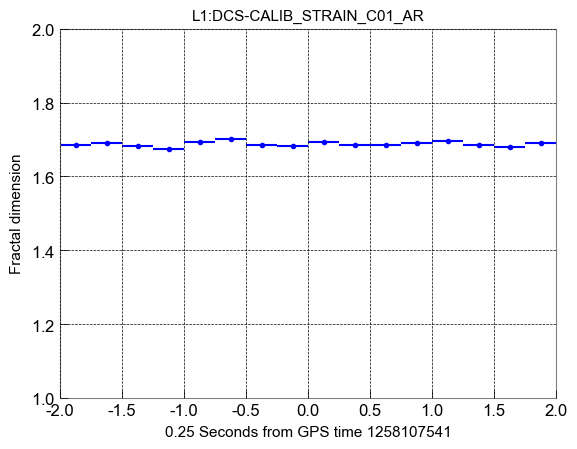

In [17]:
fig, ax = plt.subplots()
plot_min_y = 1.0
plot_max_y = 2.0

ax.set_title(channel, fontsize=11)
ax.tick_params(direction='in', length=6, width=0.5, colors='black', grid_color='r', grid_alpha=1)
ax.set_xlabel(f"{step} Seconds from GPS time {glitch_start_time}", fontsize=11)
ax.set_ylabel("Fractal dimension",fontsize=11)
ax.set_xlim([glitch_start_time,glitch_stop_time])
ax.set_ylim([plot_min_y, plot_max_y])
ax.set_xticks(np.linspace(glitch_start_time, glitch_stop_time, 9))
ax.set_xticklabels(np.linspace(-2, 2, 9))

ax.grid(which='both', axis='both', linestyle='--', color='k', linewidth=0.5)

time = data_fd['time'].values
step = time[1]-time[0]
fd = data_fd['fd'].values
ax.errorbar(time+step/2, fd, xerr=step/2, fmt='.', c='b')

## Calculate FD for all glitches in train_dir (H1 and L1)

In [18]:
filenames = []
with open("L1_glitches.txt", "r") as file:
    for line in file:
        filenames.append(line.strip())

In [ ]:
for fn in filenames:
    glitch_id = str(fn)
    start = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])-2
    stop = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])+2
    data_fd = my_gwpy_and_fractals.calculate_fd_files(start, stop, server, sampling_rate, channel, step, decimate, alpha)
    filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
    data_fd.to_csv(filename, sep='\t', index=False)

Getting the TimeSeries data
fetch_and_whiten_data: 18170.099020004272 ms
Computing the var estimator for data starting at 1256667555.0 time.
var_function: 2.991914749145508 ms
fit_est: 0.0 ms
fd= 1.6793605937792861
Computing the var estimator for data starting at 1256667555.25 time.
var_function: 1.9931793212890625 ms
fit_est: 0.9975433349609375 ms
fd= 1.6858491360896277
Computing the var estimator for data starting at 1256667555.5 time.
var_function: 3.205537796020508 ms
fit_est: 0.0 ms
fd= 1.6858400059568253
Computing the var estimator for data starting at 1256667555.75 time.
var_function: 2.2313594818115234 ms
fit_est: 0.0 ms
fd= 1.6927621893244273
Computing the var estimator for data starting at 1256667556.0 time.
var_function: 1.9946098327636719 ms
fit_est: 0.0 ms
fd= 1.6934159782106926
Computing the var estimator for data starting at 1256667556.25 time.
var_function: 1.9955635070800781 ms
fit_est: 0.0 ms
fd= 1.6831531488271145
Computing the var estimator for data starting at 1256